In [1]:
from __future__ import print_function, division
import os
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
plt.ion()  
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


![](https://miro.medium.com/max/1400/0*azmg0auRA-orU2GB)

# Reinvent the wheel ??

## Mean: Waste a great deal of time or effort in creating something that already exists

* Example: 'I have dedicated myself to learning from other people's experiences so that I do not waste time trying to reinvent the wheel.' 

Let's try!

# What is Transfer Learning?
* Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task.

* This form of transfer learning used in deep learning is called inductive transfer. This is where the scope of possible models (model bias) is narrowed in a beneficial way by using a model fit on a different but related task.

![](https://machinelearningmastery.com/wp-content/uploads/2017/09/Depiction-of-Inductive-Transfer.png)

## How to Use Transfer Learning?
* You can use transfer learning on your own predictive modeling problems.

* Two common approaches are as follows:

* Develop Model Approach

    * Select Source Task. You must select a related predictive modeling problem with an abundance of data where there is some relationship in the input data, output data, and/or concepts learned during the mapping from input to output data.
    * Develop Source Model. Next, you must develop a skillful model for this first task. The model must be better than a naive model to ensure that some feature learning has been performed.
    * Reuse Model. The model fit on the source task can then be used as the starting point for a model on the second task of interest. This may involve using all or parts of the model, depending on the modeling technique used.
    * Tune Model. Optionally, the model may need to be adapted or refined on the input-output pair data available for the task of interest.
    
* Pre-trained Model Approach
    * Select Source Model. A pre-trained source model is chosen from available models. Many research institutions release models on large and challenging datasets that may be included in the pool of candidate models from which to choose from.
    * Reuse Model. The model pre-trained model can then be used as the starting point for a model on the second task of interest. This may involve using all or parts of the model, depending on the modeling technique used.
    * Tune Model. Optionally, the model may need to be adapted or refined on the input-output pair data available for the task of interest.

### This second type of transfer learning is common in the field of deep learning. And we use that.

### Transfer Learning with Image Data
* It is common to perform transfer learning with predictive modeling problems that use image data as input.

* This may be a prediction task that takes photographs or video data as input.

* For these types of problems, it is common to use a deep learning model pre-trained for a large and challenging image classification task such as the ImageNet 1000-class photograph classification competition.

* The research organizations that develop models for this competition and do well often release their final model under a permissive license for reuse. These models can take days or weeks to train on modern hardware.

* These models can be downloaded and incorporated directly into new models that expect image data as input.

* Three examples of models of this type include:

[Oxford VGG Model](http://www.robots.ox.ac.uk/~vgg/research/very_deep/)
[Google Inception Model](https://github.com/tensorflow/models/tree/master/research/inception)
[Microsoft ResNet Model](https://github.com/KaimingHe/deep-residual-networks)

* For more examples, see the [Caffe Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo) where more pre-trained models are shared.

* This approach is effective because the images were trained on a large corpus of photographs and require the model to make predictions on a relatively large number of classes, in turn, requiring that the model efficiently learn to extract features from photographs in order to perform well on the problem.

* In their Stanford course on Convolutional Neural Networks for Visual Recognition, the authors caution to carefully choose how much of the pre-trained model to use in your new model.

![](https://3410176819-files.gitbook.io/~/files/v0/b/gitbook-legacy-files/o/assets%2F-Lwg7n_aDRMTWJvsqfEf%2Fsync%2F3f9c5916593b72e49b5c553d72d7058fbbf3e640.png?generation=1592744196727169&alt=media)

## When to Use Transfer Learning?
* Transfer learning is an optimization, a shortcut to saving time or getting better performance.

* In general, it is not obvious that there will be a benefit to using transfer learning in the domain until after the model has been developed and evaluated.

* [Lisa Torrey and Jude Shavlik in their chapter on transfer learning ](https://amzn.to/2fgeVro) describe three possible benefits to look for when using transfer learning:

    * Higher start. The initial skill (before refining the model) on the source model is higher than it otherwise would be.
    * Higher slope. The rate of improvement of skill during training of the source model is steeper than it otherwise would be.
    * Higher asymptote. The converged skill of the trained model is better than it otherwise would be.

![](https://machinelearningmastery.com/wp-content/uploads/2017/09/Three-ways-in-which-transfer-might-improve-learning-1024x505.png)


* Ideally, you would see all three benefits from a successful application of transfer learning.

* It is an approach to try if you can identify a related task with abundant data and you have the resources to develop a model for that task and reuse it on your own problem, or there is a pre-trained model available that you can use as a starting point for your own model.

* On some problems where you may not have very much data, transfer learning can enable you to develop skillful models that you simply could not develop in the absence of transfer learning.

* The choice of source data or source model is an open problem and may require domain expertise and/or intuition developed via experience.

[Reference](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)

In [2]:
data_dir = '../input/splitted-medical-mnist/data'
TRAIN = 'train'
VAL = 'valid'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.6),
        transforms.RandomRotation(degrees=10),               
        transforms.RandomResizedCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], # Gaussian Noise
                             [0.229, 0.224, 0.225])
    ]),
    VAL: transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], # Gaussian Noise
                             [0.229, 0.224, 0.225])
    ]),
    TEST: transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], # Gaussian Noise
                             [0.229, 0.224, 0.225])
   ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 30000 images under train
Loaded 12000 images under valid
Loaded 6000 images under test
Classes: 
['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']


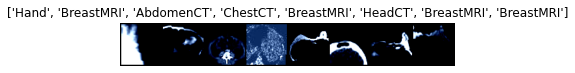

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [4]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

In [5]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [6]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

### This part is my contribution to the source code. It uses weights from a model that was previously trained in the source code. I bought the untrained version of the code, namely the vgg16 project. Here, the full connect function was not defined and was not working. So I replaced the outlayer with this code I found from the pytorch discussion site.

In [7]:
mod = list(vgg.classifier.children())
mod.pop()
mod.append(torch.nn.Linear(4096, 6))# Input Layer and output
new_classifier = torch.nn.Sequential(*mod)
vgg.classifier = new_classifier
vgg = vgg.to(device)
criterion = torch.nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(vgg.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
print("Test before training")
eval_model(vgg,criterion)

Test before training
Evaluating model
----------
Test batch 700/750
Evaluation completed in 0m 24s
Avg loss (test): 0.2483
Avg acc (test): 0.1608
----------


In [9]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=16):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)
                
            # Use half training dataset
            if i >= train_batches / 2:
                break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / dataset_sizes[TRAIN]
        avg_acc = acc_train * 2 / dataset_sizes[TRAIN]
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders[VAL]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val / dataset_sizes[VAL]
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

* I used a fairly simple dataset in this notebook. You can achieve high results with a small number of epochs. I ran 32 "epochs" initially. Results;
* 
* Training completed in 170m 7s
* Best acc: 0.9993
* 
* Test after training
* Evaluating model
* ----------
* Test batch 700/750
* Evaluation completed in 0m 30s
* Avg loss (test): 0.0004
* Avg acc (test): 0.9988
* ----------
* 
* But I think ain't nobody got a lot of time for that dataset. Please use this notebook for other datasets.

In [11]:
vgg = train_model(vgg, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=16)

Epoch 0/16
----------
Training batch 1800/1875.0
Validation batch 1400/1500
Epoch 0 result: 
Avg loss (train): 0.0118
Avg acc (train): 0.9713
Avg loss (val): 0.0006
Avg acc (val): 0.9992
----------

Epoch 1/16
----------
Training batch 1800/1875.0
Validation batch 1400/1500
Epoch 1 result: 
Avg loss (train): 0.0033
Avg acc (train): 0.9924
Avg loss (val): 0.0001
Avg acc (val): 0.9998
----------

Epoch 2/16
----------
Training batch 1800/1875.0
Validation batch 1400/1500
Epoch 2 result: 
Avg loss (train): 0.0030
Avg acc (train): 0.9933
Avg loss (val): 0.0002
Avg acc (val): 0.9998
----------

Epoch 3/16
----------
Training batch 1800/1875.0
Validation batch 1400/1500
Epoch 3 result: 
Avg loss (train): 0.0025
Avg acc (train): 0.9942
Avg loss (val): 0.0002
Avg acc (val): 0.9998
----------

Epoch 4/16
----------
Training batch 1800/1875.0
Validation batch 1400/1500
Epoch 4 result: 
Avg loss (train): 0.0011
Avg acc (train): 0.9973
Avg loss (val): 0.0006
Avg acc (val): 0.9986
----------

Epoch

In [12]:
torch.save(vgg.state_dict(), '/kaggle/working/VGG16_medical_mnist.pt')

In [13]:
print("Test after training")
eval_model(vgg,criterion)

Test after training
Evaluating model
----------
Test batch 700/750
Evaluation completed in 0m 16s
Avg loss (test): 0.0000
Avg acc (test): 1.0000
----------


Ground truth:


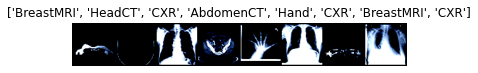

Prediction:


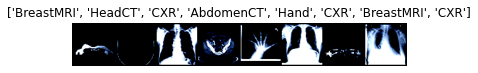

Ground truth:


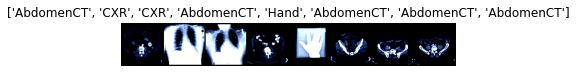

Prediction:


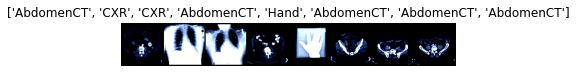

Ground truth:


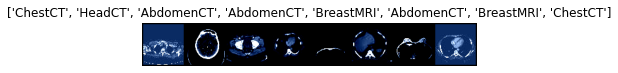

Prediction:


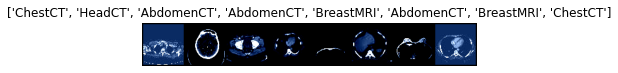

Ground truth:


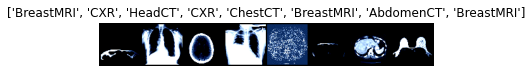

Prediction:


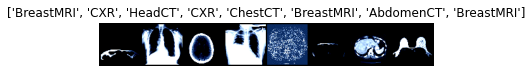

Ground truth:


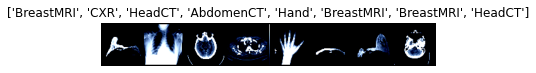

Prediction:


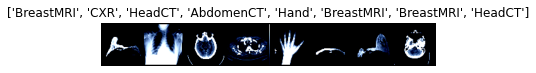

In [14]:
visualize_model(vgg, num_images=36) #test before training

# Acknowledgement

### My codes source: [https://www.kaggle.com/code/carloalbertobarbano/vgg16-transfer-learning-pytorch](https://www.kaggle.com/code/carloalbertobarbano/vgg16-transfer-learning-pytorch)
### Thank you [Carlo Alberto](https://www.kaggle.com/carloalbertobarbano)

![](https://sd.keepcalms.com/i-w600/please-follow-me-and-like-this.jpg)